# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

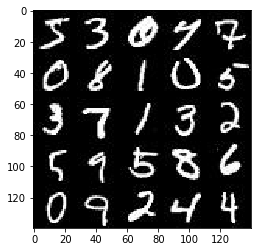

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

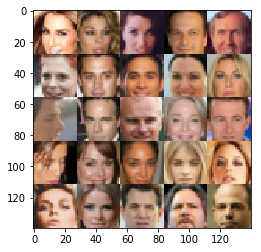

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    x = tf.placeholder(dtype=tf.float32,shape=(None,image_width,image_height,image_channels),name="inputs_x")
    z = tf.placeholder(dtype=tf.float32,shape=(None,z_dim),name="z_dim")
    learning_rate = tf.placeholder(dtype=tf.float32,shape=(),name="learning_rate")
    return x, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator",reuse=reuse):
        conv_1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        conv_1_bn = tf.layers.batch_normalization(conv_1, training=True)
        relu1 = tf.maximum(alpha * conv_1_bn, conv_1_bn)
        # 14x14x64
        
        conv_2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        conv_2_bn = tf.layers.batch_normalization(conv_2, training=True)
        relu2 = tf.maximum(alpha * conv_2_bn, conv_2_bn)
        # 7x7x128
        
        conv_3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        conv_3_bn = tf.layers.batch_normalization(conv_3, training=True)
        relu3 = tf.maximum(alpha * conv_3_bn, conv_3_bn)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator',reuse=not(is_train)):
        # Reshape it to start the convolutional stack
        fc = tf.layers.dense(z, 4*4*512)
        x = tf.reshape(fc, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        relu_x = tf.maximum(alpha * x, x)
        # 4x4x512 now

        #conv2d_1_t = tf.nn.conv2d_transpose(relu_x, kernel, output_shape=[64,7,7,256], strides=[1,2,2,1], padding='SAME')
        conv2d_1_t = tf.layers.conv2d_transpose(relu_x, 256,4, strides=1, padding='valid')
        conv2d_1_t_bn = tf.layers.batch_normalization(conv2d_1_t, training=is_train)
        relu1 = tf.maximum(alpha * conv2d_1_t_bn, conv2d_1_t_bn)
        # 7x7x256 now
        
        conv2d_2_t = tf.layers.conv2d_transpose(relu1, 128, 4, strides=2, padding='same')
        conv2d_2_t_bn = tf.layers.batch_normalization(conv2d_2_t, training=is_train)
        relu2 = tf.maximum(alpha * conv2d_2_t_bn, conv2d_2_t_bn)
        # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 4, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_f = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1 - 0.1)))
    
    d_loss_f = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_f, labels=tf.zeros_like(d_logits_f)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_f, labels=tf.ones_like(d_logits_f)))

    d_loss = d_loss_real + d_loss_f
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real,input_z, lr = model_inputs(*data_shape[1:], z_dim)
    
    out_channel_dim = 1
    if data_image_mode == "RGB" : 
        out_channel_dim = 3
    d_loss, g_loss = model_loss(input_real,input_z,out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss,g_loss,lr,beta1)

    steps = 0
    start = time.clock()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                #print(batch_images)
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr :learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr :learning_rate})
                if steps % 100 == 0:
                    end = time.clock()
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Time: {:.4f}s ...Epoch {}/{}...setp:{}...".format((end - start),epoch_i+1, epoch_count,steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    start = time.clock()
                if steps % 500 == 0:
                    show_generator_output(sess,4,input_z,out_channel_dim,data_image_mode)
        show_generator_output(sess,4,input_z,out_channel_dim,data_image_mode)
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Time: 88.3452s ...Epoch 1/2...setp:100... Discriminator Loss: 0.4706... Generator Loss: 2.9398
Time: 87.0764s ...Epoch 1/2...setp:200... Discriminator Loss: 0.8811... Generator Loss: 1.7949
Time: 86.8983s ...Epoch 1/2...setp:300... Discriminator Loss: 1.4314... Generator Loss: 0.6192
Time: 87.0601s ...Epoch 1/2...setp:400... Discriminator Loss: 1.2978... Generator Loss: 0.6342
Time: 85.8872s ...Epoch 1/2...setp:500... Discriminator Loss: 1.0423... Generator Loss: 1.0880


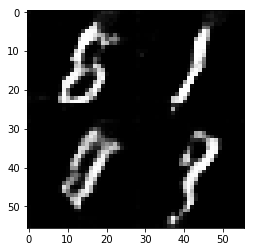

Time: 86.8448s ...Epoch 1/2...setp:600... Discriminator Loss: 1.1839... Generator Loss: 0.7944
Time: 87.5048s ...Epoch 1/2...setp:700... Discriminator Loss: 1.2263... Generator Loss: 0.6208
Time: 86.3639s ...Epoch 1/2...setp:800... Discriminator Loss: 1.3619... Generator Loss: 0.5400
Time: 86.3613s ...Epoch 1/2...setp:900... Discriminator Loss: 0.9367... Generator Loss: 1.0246
Time: 86.3824s ...Epoch 1/2...setp:1000... Discriminator Loss: 1.1278... Generator Loss: 0.7662


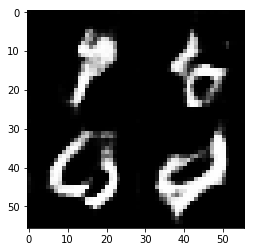

Time: 86.9503s ...Epoch 1/2...setp:1100... Discriminator Loss: 0.7621... Generator Loss: 1.5411
Time: 86.4675s ...Epoch 1/2...setp:1200... Discriminator Loss: 0.6279... Generator Loss: 1.9167
Time: 86.3701s ...Epoch 1/2...setp:1300... Discriminator Loss: 1.3480... Generator Loss: 0.5234
Time: 86.7474s ...Epoch 1/2...setp:1400... Discriminator Loss: 1.6232... Generator Loss: 0.4033
Time: 86.9801s ...Epoch 1/2...setp:1500... Discriminator Loss: 0.9080... Generator Loss: 2.2744


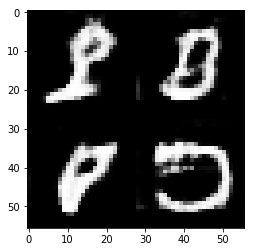

Time: 87.0501s ...Epoch 1/2...setp:1600... Discriminator Loss: 1.5478... Generator Loss: 0.4514
Time: 86.4249s ...Epoch 1/2...setp:1700... Discriminator Loss: 0.7240... Generator Loss: 2.1331
Time: 86.6852s ...Epoch 1/2...setp:1800... Discriminator Loss: 0.8329... Generator Loss: 2.8219
Time: 85.8697s ...Epoch 2/2...setp:1900... Discriminator Loss: 0.9908... Generator Loss: 0.9629
Time: 85.4014s ...Epoch 2/2...setp:2000... Discriminator Loss: 0.6601... Generator Loss: 1.5209


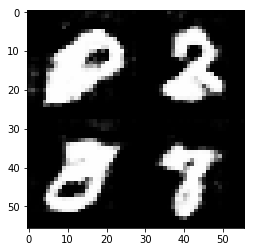

Time: 87.4850s ...Epoch 2/2...setp:2100... Discriminator Loss: 0.5444... Generator Loss: 2.2116
Time: 86.5040s ...Epoch 2/2...setp:2200... Discriminator Loss: 1.2865... Generator Loss: 0.7651
Time: 86.5937s ...Epoch 2/2...setp:2300... Discriminator Loss: 0.7994... Generator Loss: 1.2834
Time: 86.7838s ...Epoch 2/2...setp:2400... Discriminator Loss: 1.2500... Generator Loss: 0.6592
Time: 85.5240s ...Epoch 2/2...setp:2500... Discriminator Loss: 0.8612... Generator Loss: 1.1108


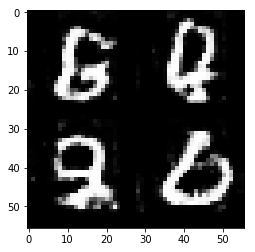

Time: 86.6467s ...Epoch 2/2...setp:2600... Discriminator Loss: 0.6041... Generator Loss: 1.8058
Time: 85.4569s ...Epoch 2/2...setp:2700... Discriminator Loss: 0.8247... Generator Loss: 1.1864
Time: 85.6637s ...Epoch 2/2...setp:2800... Discriminator Loss: 0.7439... Generator Loss: 1.2974
Time: 85.7594s ...Epoch 2/2...setp:2900... Discriminator Loss: 0.5667... Generator Loss: 2.1529
Time: 85.4150s ...Epoch 2/2...setp:3000... Discriminator Loss: 1.0611... Generator Loss: 0.8970


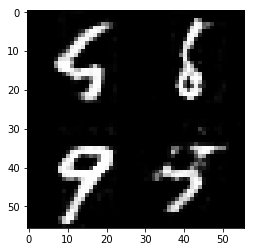

Time: 85.8947s ...Epoch 2/2...setp:3100... Discriminator Loss: 0.7438... Generator Loss: 1.2945
Time: 84.9697s ...Epoch 2/2...setp:3200... Discriminator Loss: 0.8937... Generator Loss: 2.9344
Time: 86.1244s ...Epoch 2/2...setp:3300... Discriminator Loss: 0.6801... Generator Loss: 1.5318
Time: 85.0500s ...Epoch 2/2...setp:3400... Discriminator Loss: 1.5422... Generator Loss: 0.4850
Time: 85.2140s ...Epoch 2/2...setp:3500... Discriminator Loss: 0.7596... Generator Loss: 1.7997


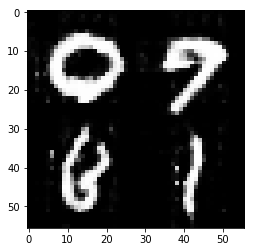

Time: 85.9586s ...Epoch 2/2...setp:3600... Discriminator Loss: 1.1990... Generator Loss: 0.8286
Time: 86.3066s ...Epoch 2/2...setp:3700... Discriminator Loss: 1.0023... Generator Loss: 1.0783


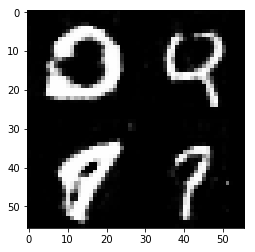

In [12]:
import time
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Time: 48.0408s ...Epoch 1/1...setp:100... Discriminator Loss: 0.5690... Generator Loss: 2.6139
Time: 45.9536s ...Epoch 1/1...setp:200... Discriminator Loss: 1.1790... Generator Loss: 1.1181
Time: 45.7202s ...Epoch 1/1...setp:300... Discriminator Loss: 1.0347... Generator Loss: 1.2177
Time: 46.0915s ...Epoch 1/1...setp:400... Discriminator Loss: 1.3169... Generator Loss: 1.1523
Time: 46.2687s ...Epoch 1/1...setp:500... Discriminator Loss: 1.1496... Generator Loss: 0.7543


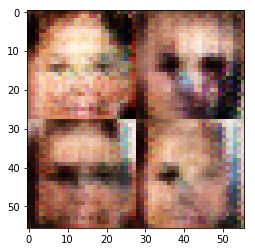

Time: 46.5444s ...Epoch 1/1...setp:600... Discriminator Loss: 1.1732... Generator Loss: 0.6780
Time: 45.9626s ...Epoch 1/1...setp:700... Discriminator Loss: 1.6860... Generator Loss: 0.4044
Time: 45.6179s ...Epoch 1/1...setp:800... Discriminator Loss: 1.3424... Generator Loss: 1.0625
Time: 46.1800s ...Epoch 1/1...setp:900... Discriminator Loss: 1.2246... Generator Loss: 0.7396
Time: 45.8840s ...Epoch 1/1...setp:1000... Discriminator Loss: 1.4201... Generator Loss: 0.5670


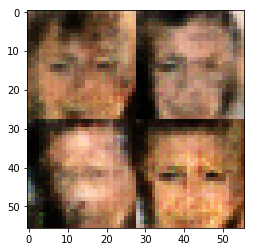

Time: 46.4191s ...Epoch 1/1...setp:1100... Discriminator Loss: 1.3965... Generator Loss: 0.5727
Time: 46.0942s ...Epoch 1/1...setp:1200... Discriminator Loss: 1.2070... Generator Loss: 0.7480
Time: 46.0859s ...Epoch 1/1...setp:1300... Discriminator Loss: 1.2974... Generator Loss: 0.6813
Time: 46.3981s ...Epoch 1/1...setp:1400... Discriminator Loss: 1.3632... Generator Loss: 0.5575
Time: 46.2845s ...Epoch 1/1...setp:1500... Discriminator Loss: 1.2392... Generator Loss: 0.6699


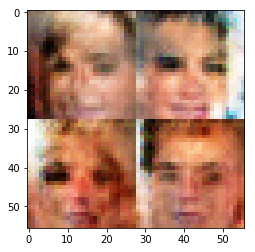

Time: 47.1879s ...Epoch 1/1...setp:1600... Discriminator Loss: 1.2015... Generator Loss: 0.7848
Time: 46.2797s ...Epoch 1/1...setp:1700... Discriminator Loss: 1.1344... Generator Loss: 0.8495
Time: 46.3928s ...Epoch 1/1...setp:1800... Discriminator Loss: 1.2916... Generator Loss: 0.6076
Time: 46.1810s ...Epoch 1/1...setp:1900... Discriminator Loss: 1.1914... Generator Loss: 0.8366
Time: 45.9787s ...Epoch 1/1...setp:2000... Discriminator Loss: 1.2340... Generator Loss: 0.9395


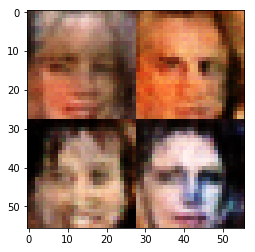

Time: 46.3690s ...Epoch 1/1...setp:2100... Discriminator Loss: 1.3766... Generator Loss: 0.9232
Time: 45.9292s ...Epoch 1/1...setp:2200... Discriminator Loss: 1.3238... Generator Loss: 0.8574
Time: 46.2497s ...Epoch 1/1...setp:2300... Discriminator Loss: 1.2658... Generator Loss: 0.7261
Time: 46.1281s ...Epoch 1/1...setp:2400... Discriminator Loss: 1.2446... Generator Loss: 0.7597
Time: 45.9671s ...Epoch 1/1...setp:2500... Discriminator Loss: 1.0790... Generator Loss: 0.7960


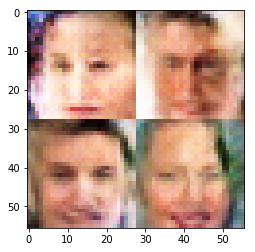

Time: 50.4607s ...Epoch 1/1...setp:2600... Discriminator Loss: 1.2069... Generator Loss: 0.8586
Time: 46.1260s ...Epoch 1/1...setp:2700... Discriminator Loss: 1.3563... Generator Loss: 0.5328
Time: 46.1419s ...Epoch 1/1...setp:2800... Discriminator Loss: 1.3243... Generator Loss: 0.6739
Time: 46.1989s ...Epoch 1/1...setp:2900... Discriminator Loss: 1.4524... Generator Loss: 0.5519
Time: 46.0156s ...Epoch 1/1...setp:3000... Discriminator Loss: 1.2637... Generator Loss: 0.6360


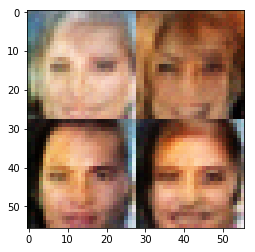

Time: 46.8205s ...Epoch 1/1...setp:3100... Discriminator Loss: 1.2987... Generator Loss: 0.8192
Time: 46.1009s ...Epoch 1/1...setp:3200... Discriminator Loss: 1.2051... Generator Loss: 0.8035
Time: 46.0479s ...Epoch 1/1...setp:3300... Discriminator Loss: 1.3222... Generator Loss: 0.5375
Time: 45.9153s ...Epoch 1/1...setp:3400... Discriminator Loss: 1.1348... Generator Loss: 0.7888
Time: 45.8006s ...Epoch 1/1...setp:3500... Discriminator Loss: 1.2242... Generator Loss: 0.9776


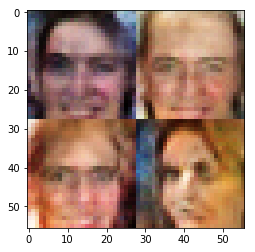

Time: 46.5806s ...Epoch 1/1...setp:3600... Discriminator Loss: 1.3659... Generator Loss: 1.0312
Time: 46.1258s ...Epoch 1/1...setp:3700... Discriminator Loss: 1.1369... Generator Loss: 0.7648
Time: 46.2296s ...Epoch 1/1...setp:3800... Discriminator Loss: 1.4753... Generator Loss: 0.4250
Time: 46.3205s ...Epoch 1/1...setp:3900... Discriminator Loss: 1.5018... Generator Loss: 0.5260
Time: 46.7615s ...Epoch 1/1...setp:4000... Discriminator Loss: 1.2108... Generator Loss: 0.6692


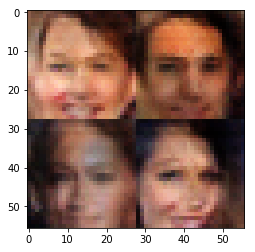

Time: 46.9808s ...Epoch 1/1...setp:4100... Discriminator Loss: 1.1440... Generator Loss: 0.9316
Time: 46.3608s ...Epoch 1/1...setp:4200... Discriminator Loss: 1.4996... Generator Loss: 0.8154
Time: 46.3844s ...Epoch 1/1...setp:4300... Discriminator Loss: 1.3322... Generator Loss: 0.6146
Time: 46.7438s ...Epoch 1/1...setp:4400... Discriminator Loss: 1.0843... Generator Loss: 1.2369
Time: 46.2869s ...Epoch 1/1...setp:4500... Discriminator Loss: 1.5085... Generator Loss: 0.4366


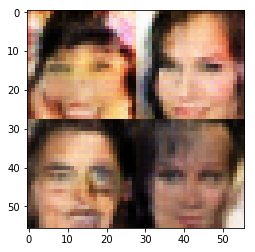

Time: 46.6290s ...Epoch 1/1...setp:4600... Discriminator Loss: 1.2139... Generator Loss: 0.8210
Time: 46.1208s ...Epoch 1/1...setp:4700... Discriminator Loss: 1.1717... Generator Loss: 0.9849
Time: 45.9603s ...Epoch 1/1...setp:4800... Discriminator Loss: 1.3263... Generator Loss: 0.7399
Time: 46.5609s ...Epoch 1/1...setp:4900... Discriminator Loss: 1.3366... Generator Loss: 0.9376
Time: 46.4137s ...Epoch 1/1...setp:5000... Discriminator Loss: 1.2106... Generator Loss: 1.1713


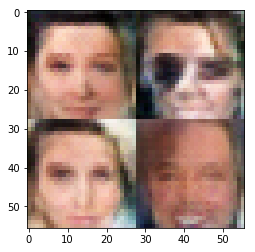

Time: 46.7385s ...Epoch 1/1...setp:5100... Discriminator Loss: 1.5451... Generator Loss: 0.4668
Time: 46.0741s ...Epoch 1/1...setp:5200... Discriminator Loss: 1.0098... Generator Loss: 0.8696
Time: 46.2526s ...Epoch 1/1...setp:5300... Discriminator Loss: 1.2686... Generator Loss: 0.7219
Time: 46.2343s ...Epoch 1/1...setp:5400... Discriminator Loss: 1.2330... Generator Loss: 0.7669
Time: 45.9968s ...Epoch 1/1...setp:5500... Discriminator Loss: 1.4281... Generator Loss: 0.5449


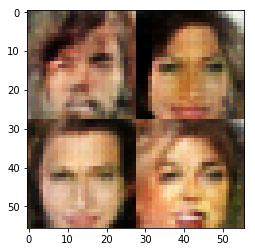

Time: 46.6610s ...Epoch 1/1...setp:5600... Discriminator Loss: 1.3935... Generator Loss: 0.6179
Time: 45.9901s ...Epoch 1/1...setp:5700... Discriminator Loss: 1.2383... Generator Loss: 0.7489
Time: 46.0970s ...Epoch 1/1...setp:5800... Discriminator Loss: 1.0581... Generator Loss: 1.0516
Time: 46.1044s ...Epoch 1/1...setp:5900... Discriminator Loss: 1.1028... Generator Loss: 1.0562
Time: 46.1214s ...Epoch 1/1...setp:6000... Discriminator Loss: 1.2146... Generator Loss: 0.6433


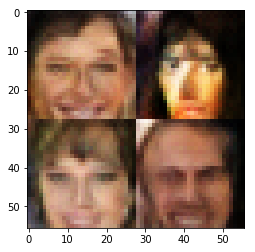

Time: 46.5742s ...Epoch 1/1...setp:6100... Discriminator Loss: 1.3504... Generator Loss: 0.6243
Time: 46.4546s ...Epoch 1/1...setp:6200... Discriminator Loss: 1.4753... Generator Loss: 0.5412
Time: 46.2062s ...Epoch 1/1...setp:6300... Discriminator Loss: 1.1335... Generator Loss: 0.9319
Time: 46.0757s ...Epoch 1/1...setp:6400... Discriminator Loss: 1.3478... Generator Loss: 0.7720
Time: 46.1601s ...Epoch 1/1...setp:6500... Discriminator Loss: 1.2923... Generator Loss: 0.6116


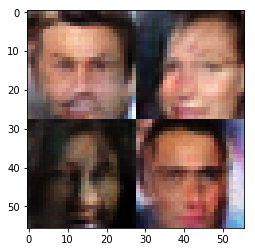

Time: 46.6654s ...Epoch 1/1...setp:6600... Discriminator Loss: 1.3612... Generator Loss: 0.6158
Time: 46.1766s ...Epoch 1/1...setp:6700... Discriminator Loss: 1.3229... Generator Loss: 0.5691
Time: 46.0047s ...Epoch 1/1...setp:6800... Discriminator Loss: 1.1326... Generator Loss: 0.7448
Time: 46.3046s ...Epoch 1/1...setp:6900... Discriminator Loss: 1.3742... Generator Loss: 0.5422
Time: 46.5668s ...Epoch 1/1...setp:7000... Discriminator Loss: 1.4594... Generator Loss: 0.5530


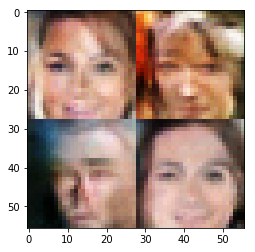

Time: 46.6922s ...Epoch 1/1...setp:7100... Discriminator Loss: 1.5384... Generator Loss: 0.5385
Time: 46.2870s ...Epoch 1/1...setp:7200... Discriminator Loss: 1.1136... Generator Loss: 0.8628
Time: 46.1344s ...Epoch 1/1...setp:7300... Discriminator Loss: 1.5563... Generator Loss: 0.5051
Time: 46.6955s ...Epoch 1/1...setp:7400... Discriminator Loss: 1.2197... Generator Loss: 0.8740
Time: 45.9771s ...Epoch 1/1...setp:7500... Discriminator Loss: 1.4709... Generator Loss: 0.5108


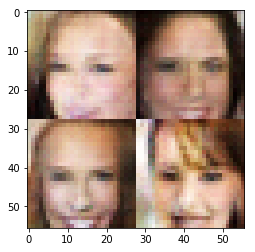

Time: 46.3881s ...Epoch 1/1...setp:7600... Discriminator Loss: 1.3789... Generator Loss: 0.7076
Time: 45.8866s ...Epoch 1/1...setp:7700... Discriminator Loss: 1.4562... Generator Loss: 0.4181
Time: 45.8910s ...Epoch 1/1...setp:7800... Discriminator Loss: 1.2178... Generator Loss: 0.8700
Time: 46.4684s ...Epoch 1/1...setp:7900... Discriminator Loss: 1.0906... Generator Loss: 0.9735
Time: 46.1031s ...Epoch 1/1...setp:8000... Discriminator Loss: 1.3483... Generator Loss: 0.7241


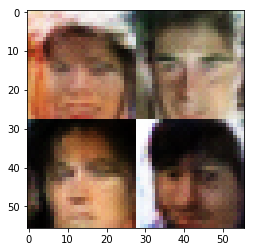

Time: 46.7376s ...Epoch 1/1...setp:8100... Discriminator Loss: 1.5258... Generator Loss: 0.5333
Time: 46.2321s ...Epoch 1/1...setp:8200... Discriminator Loss: 1.4035... Generator Loss: 0.7716
Time: 46.7847s ...Epoch 1/1...setp:8300... Discriminator Loss: 1.1898... Generator Loss: 0.8992
Time: 46.3941s ...Epoch 1/1...setp:8400... Discriminator Loss: 1.1561... Generator Loss: 1.0210
Time: 46.3007s ...Epoch 1/1...setp:8500... Discriminator Loss: 1.0193... Generator Loss: 0.8388


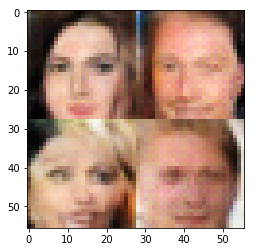

Time: 46.7149s ...Epoch 1/1...setp:8600... Discriminator Loss: 1.4555... Generator Loss: 0.4890
Time: 46.3765s ...Epoch 1/1...setp:8700... Discriminator Loss: 1.4652... Generator Loss: 0.4541
Time: 46.3388s ...Epoch 1/1...setp:8800... Discriminator Loss: 1.4343... Generator Loss: 0.5258
Time: 46.0954s ...Epoch 1/1...setp:8900... Discriminator Loss: 1.2733... Generator Loss: 0.6297
Time: 45.9141s ...Epoch 1/1...setp:9000... Discriminator Loss: 1.1280... Generator Loss: 0.8329


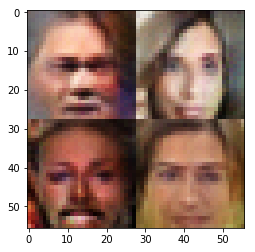

Time: 46.4173s ...Epoch 1/1...setp:9100... Discriminator Loss: 1.2236... Generator Loss: 0.9211
Time: 46.0639s ...Epoch 1/1...setp:9200... Discriminator Loss: 1.0629... Generator Loss: 1.6049
Time: 46.2810s ...Epoch 1/1...setp:9300... Discriminator Loss: 0.8643... Generator Loss: 1.2487
Time: 47.1386s ...Epoch 1/1...setp:9400... Discriminator Loss: 1.1668... Generator Loss: 0.7328
Time: 46.6587s ...Epoch 1/1...setp:9500... Discriminator Loss: 1.1915... Generator Loss: 0.7335


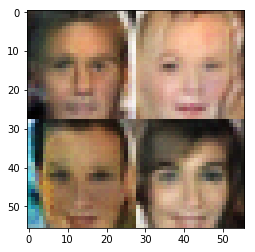

Time: 48.1197s ...Epoch 1/1...setp:9600... Discriminator Loss: 1.3434... Generator Loss: 0.6314
Time: 46.5063s ...Epoch 1/1...setp:9700... Discriminator Loss: 1.4045... Generator Loss: 0.6027
Time: 47.4345s ...Epoch 1/1...setp:9800... Discriminator Loss: 1.1419... Generator Loss: 0.7321
Time: 46.2951s ...Epoch 1/1...setp:9900... Discriminator Loss: 1.1732... Generator Loss: 0.8332
Time: 46.2013s ...Epoch 1/1...setp:10000... Discriminator Loss: 1.5635... Generator Loss: 0.4309


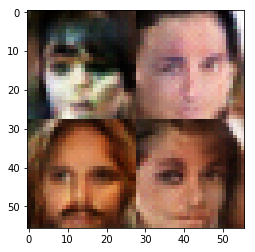

Time: 46.7887s ...Epoch 1/1...setp:10100... Discriminator Loss: 1.1998... Generator Loss: 0.8328
Time: 46.0497s ...Epoch 1/1...setp:10200... Discriminator Loss: 1.2562... Generator Loss: 0.6419
Time: 46.6924s ...Epoch 1/1...setp:10300... Discriminator Loss: 1.1233... Generator Loss: 0.7380
Time: 46.5330s ...Epoch 1/1...setp:10400... Discriminator Loss: 1.5120... Generator Loss: 0.4428
Time: 46.7020s ...Epoch 1/1...setp:10500... Discriminator Loss: 1.0845... Generator Loss: 0.8932


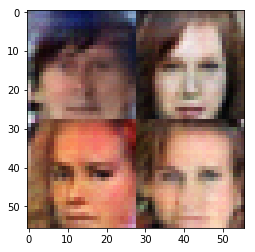

Time: 47.0642s ...Epoch 1/1...setp:10600... Discriminator Loss: 1.1913... Generator Loss: 0.7337
Time: 46.6973s ...Epoch 1/1...setp:10700... Discriminator Loss: 1.2822... Generator Loss: 0.7011
Time: 46.6587s ...Epoch 1/1...setp:10800... Discriminator Loss: 1.2945... Generator Loss: 1.2051
Time: 47.2376s ...Epoch 1/1...setp:10900... Discriminator Loss: 1.4328... Generator Loss: 0.4965
Time: 45.6319s ...Epoch 1/1...setp:11000... Discriminator Loss: 1.3275... Generator Loss: 0.5626


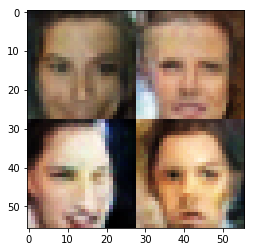

Time: 46.1833s ...Epoch 1/1...setp:11100... Discriminator Loss: 1.1273... Generator Loss: 1.0053
Time: 45.6676s ...Epoch 1/1...setp:11200... Discriminator Loss: 1.1217... Generator Loss: 0.8511
Time: 45.7139s ...Epoch 1/1...setp:11300... Discriminator Loss: 1.4577... Generator Loss: 0.4889
Time: 45.4600s ...Epoch 1/1...setp:11400... Discriminator Loss: 1.0228... Generator Loss: 0.9084
Time: 45.3766s ...Epoch 1/1...setp:11500... Discriminator Loss: 1.3575... Generator Loss: 0.5886


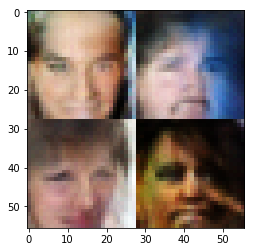

Time: 46.2290s ...Epoch 1/1...setp:11600... Discriminator Loss: 1.4111... Generator Loss: 0.5422
Time: 45.4683s ...Epoch 1/1...setp:11700... Discriminator Loss: 1.0102... Generator Loss: 0.8789
Time: 45.4651s ...Epoch 1/1...setp:11800... Discriminator Loss: 0.8243... Generator Loss: 1.1399
Time: 45.4111s ...Epoch 1/1...setp:11900... Discriminator Loss: 1.2141... Generator Loss: 0.6745
Time: 45.3818s ...Epoch 1/1...setp:12000... Discriminator Loss: 0.7365... Generator Loss: 1.3504


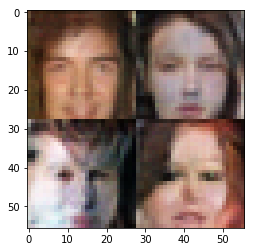

Time: 45.9338s ...Epoch 1/1...setp:12100... Discriminator Loss: 1.0737... Generator Loss: 0.8992
Time: 45.4635s ...Epoch 1/1...setp:12200... Discriminator Loss: 0.9437... Generator Loss: 1.1731
Time: 45.5631s ...Epoch 1/1...setp:12300... Discriminator Loss: 0.9586... Generator Loss: 1.5842
Time: 45.4132s ...Epoch 1/1...setp:12400... Discriminator Loss: 0.7732... Generator Loss: 2.2156
Time: 45.4434s ...Epoch 1/1...setp:12500... Discriminator Loss: 0.5900... Generator Loss: 2.1538


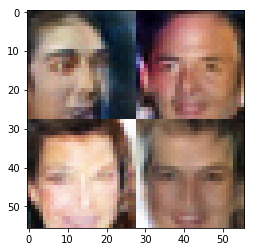

Time: 46.0260s ...Epoch 1/1...setp:12600... Discriminator Loss: 1.4293... Generator Loss: 1.9255


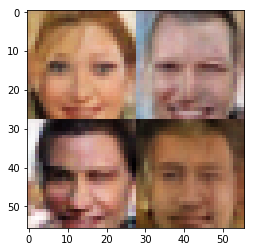

In [13]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。